In [ ]:
# Loading libraries
import pandas as pd
import os
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta
from datetime import datetime
from pandas_datareader import data

import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from pathlib import Path
from bs4 import BeautifulSoup
import codecs

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from random import randrange

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from tensorflow import keras


from sklearn.model_selection import train_test_split
from official.nlp import optimization  # to create AdamW optmizer

from sklearn import metrics


In [ ]:
class BagOfWords():
    def __init__(self):
        self.__masterDict = pd.DataFrame()
        
        
    def loadMasterDictionary(self, dict_path):
        self.__masterDict=pd.read_csv(dict_path)
        negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]
        
        self.__lm_dict = {
            'positive': self.__getPositiveWords()
            , 'negative' : self.__getNegativeWords()
            , 'negate' : negate
        }
        
    def checkWordSentiment(self, word):
        if word in self.__lm_dict['negative']:
            print(f'{word} is a negative word')
        elif word in self.__lm_dict['positive']:
            print(f'{word} is a positive word')
        else:
            print(f'{word} is a nautral word')


    def isNegatedWord(self, word):
        if word in self.__lm_dict['negate']:
            return True
        return False

    def sentimentCount(self, input_words, title, useNegateWords):
        pos_count = 0
        neg_count = 0

        pos_words = []
        neg_words = []

        word_count = len(input_words)

        for i in range(0, word_count):
            if input_words[i] in self.__lm_dict['negative']:
                neg_count += 1
                neg_words.append(input_words[i])
            if input_words[i] in self.__lm_dict['positive']:
                if useNegateWords and i >= 3:
                    if self.isNegatedWord(input_words[i - 1]) or self.isNegatedWord(input_words[i - 2]) or self.isNegatedWord(input_words[i - 3]):
                        neg_count += 1
                        neg_words.append(input_words[i] + ' (with negation)')
                    else:
                        pos_count += 1
                        pos_words.append(input_words[i])
                elif useNegateWords and i == 2:
                    if self.isNegatedWord(input_words[i - 1]) or self.isNegatedWord(input_words[i - 2]):
                        neg_count += 1
                        neg_words.append(input_words[i] + ' (with negation)')
                    else:
                        pos_count += 1
                        pos_words.append(input_words[i])
                elif useNegateWords and i == 1:
                    if self.isNegatedWord(input_words[i - 1]):
                        neg_count += 1
                        neg_words.append(input_words[i] + ' (with negation)')
                    else:
                        pos_count += 1
                        pos_words.append(input_words[i])
                elif useNegateWords and i == 0:
                    pos_count += 1
                    pos_words.append(input_words[i])
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
        
        #print(f'Results for {title}\n')
        #print('The # of positive words:', pos_count)
        #print('The # of negative words:', neg_count)
        #  print('The list of found positive words:', pos_words)
        # print('The list of found negative words:', neg_words)
        #print('\n')

        results = [word_count, pos_count, neg_count, pos_words, neg_words]

        return results
        
        
    def __getPositiveWords(self):
        positive_df = self.__masterDict.loc[self.__masterDict['Positive'] > 0]
        positive_words = positive_df['Word']
        positive_words = [word.lower() for word in positive_words]
        return positive_words
    
    def __getNegativeWords(self):
        positive_df = self.__masterDict.loc[self.__masterDict['Negative'] > 0]
        positive_words = positive_df['Word']
        positive_words = [word.lower() for word in positive_words]
        return positive_words
        

In [ ]:
class SharePriceAnalyzer():
    
    def __init__(self, df):
        self.__share_prices_dict = {} 
        self.__getSharePricesAsDict(df)
    
    

    def plotSharePricesByKey(self, key, price_list):
    
        plt.plot(price_list,marker="o")
        plt.xlabel("Days")
        plt.ylabel("Share prices")
        plt.title(key + " Share Prices Around Earning Call Date")
        plt.axvline(x=7, color='k', linestyle='--')
        plt.show()
    


    def plotSharePrices(self, index):
        key = list(self.__share_prices_dict)[index]
        plotSharePricesByKey(key, self.__share_prices_dict[key])
    
    
    
    # Possible sentimet_type values:
    #    AvgNetPriceChange - Average net price change difference before and after the call
    #    FirstDayChange - Price change between the day of the earning call and the following day.
    #    PostCallNetChange - Average net price change in the week after the earning call
    #    PostCallPctChange - The percent change in prices between the day of the call and the week after the call
    def getSentiment(self, key, sentiment_type='AvgNetPriceChange', do_printout = False, breaking_point_pct_value = 0):
        if sentiment_type == 'AvgNetPriceChange':
            return self.__getAvgNetPriceChangeSentiment(key, do_printout)
        elif sentiment_type == 'FirstDayChange':
            return self.__getFirstDayChange(key, do_printout)
        elif sentiment_type == 'PostCallNetChange':
            return self.__getPostCallNetAvg(key, do_printout)
        elif sentiment_type == 'PostCallPctChange':
            return self.__getPostCallPctChange(key=key, breaking_point_pct_value=breaking_point_pct_value, do_printout=do_printout)
        else:
            raise ValueError('Unsupported sentiment_type value')
        


    def showNetSharePriceChanges(self, index):
        key = list(self.__share_prices_dict)[index]
        self.__showNetSharePriceChangesByKey(key)

        

    def __getSharePricesAsDict(self, df):
        self.__share_prices_dict = {} 
        for index in range(len(df)):
            ticker = df.loc[index, 'Ticker']
            arr = []
            for i in range(-7, 8):
                arr.append(df.loc[index, 'SharePrice' + str(i)])
        
            self.__share_prices_dict[ticker] = arr
        return self.__share_prices_dict

    
    
    def __showNetSharePriceChangesByKey(self, key): 
        price_list = self.__share_prices_dict[key]
        self.plotSharePricesByKey(key, price_list)
        net_price_change = self.__calculateAvgNetChange(self.__share_prices_dict[key])
        print(f'net price change = {net_price_change}')
    
        net_price_change_before = self.__calculateAvgNetChange(self.__share_prices_dict[key][0:6])
        print(f'net price change BEFORE call = {net_price_change_before}')
    
        net_price_change_after = self.__calculateAvgNetChange(self.__share_prices_dict[key][6:len(self.__share_prices_dict[key])])
        print(f'net price change AFTER call= {net_price_change_after}')
    
        sentiment_val = self.getSentiment(key, sentiment_type='AvgNetPriceChange', do_printout=True)
        sentiment = ''
        if sentiment_val == 0:
            sentiment = 'Positive'
        elif sentiment_val == 1:
            sentiment = 'Negative'
        elif sentiment_val == 2:
            sentiment = 'Neutral'
        else:
            sentiment = 'N/A'
        print(f'\nSentiment: {sentiment}')
        
        
        
    def __calculateAvgNetChange(self, price_list):
        list_length = len(price_list)
        if list_length == 0:
            return 0
        if list_length == 1:
            return price_list[0]
        total_price_change = 0
        for i in range(1, list_length):
            price_change = (price_list[i] - price_list[i-1])
            #print(price_change)
            total_price_change = total_price_change + price_change
        return total_price_change / (list_length - 1)
    
    
    # Current algorithm to decide sentiment is simple: If the average net price 
    # change prior to the earning call is negative and the average net price change 
    # post-earning call is positive, than the sentiment is Positive.
    # If the average net price change prior to the earning call is positive and the average net price 
    # change post-earning call is negative, than the sentiment is Negative Otherwise the sentiment is neutral.
    def __getAvgNetPriceChangeSentiment(self, key, do_printout):
        net_price_change_before = self.__calculateAvgNetChange(self.__share_prices_dict[key][0:6])
        if do_printout == True:
            print(f'net price change BEFORE call = {net_price_change_before}')
        net_price_change_after = self.__calculateAvgNetChange(self.__share_prices_dict[key][6:len(self.__share_prices_dict[key])])
        if do_printout == True:
            print(f'net price change AFTER call= {net_price_change_after}')
        if net_price_change_before < 0 and net_price_change_after > 0:
            return 1 # Positive
        elif net_price_change_before > 0 and net_price_change_after < 0:
            return 0 # Negative
        return 2 # Neutral
    
    
    
    def __getFirstDayChange(self, key, do_printout):
        one_day_change = self.__calculateAvgNetChange(self.__share_prices_dict[key][7:9])
        if one_day_change < 0:
            return 0 # Negative
        elif one_day_change > 0:
            return 1 # Positive
        return 2 # Neutral
    
    
    def __getPostCallNetAvg(self, key, do_printout):
        net_change = self.__calculateAvgNetChange(self.__share_prices_dict[key][7:len(self.__share_prices_dict[key])])
        if net_change < 0:
            return 0 # Negative
        elif net_change > 0:
            return 1 # Positive
        return 2 # Neutral
        
        
        
    def __getPostCallPctChange(self, key, breaking_point_pct_value, do_printout):
        earning_call_price = self.__share_prices_dict[key][7]
        last_day_price = self.__share_prices_dict[key][len(self.__share_prices_dict[key])-1]
        #print(f'earning_call_price: {earning_call_price}')
        #print(f'last_day_price: {last_day_price}')
        if last_day_price == 0:
            raise ValueError('last_day_price is zero')
        pct = (last_day_price - earning_call_price) / last_day_price
        #print(f'pct: {pct}')
        if pct < breaking_point_pct_value:
            return 0 # Negative
        elif pct > breaking_point_pct_value:
            return 1 # Popsitive
        return 2 # Neutral

In [ ]:
class EarningCallsCorpus():
    def __init__(self, root_dir, use_colab=False):
        self_root_dit = root_dir
        self.use_colab = use_colab
        
    @property
    def df(self):
        return self.__df
    
    def cleanHtmlFiles(self, srcDir, destDir):
        Path(destDir).mkdir(parents=True, exist_ok=True)

        for dirName, subdirList, fileList in os.walk(srcDir):
            print('Found directory: %s' % dirName)
            for fname in fileList:
                #extension = os.path.splitext(fname)[1]
                if fname.endswith('.html'):
                    # Get full path
                    srcFilePath = dirName + '/' + fname
                    # Set destination file path
                    destFilePath = destDir + '/' + fname.replace('html', 'txt')
                    if path.exists(destFilePath):
                        print(f'Destination path alread exists - {destFilePath}')
                        continue
                    print(f'\t{srcFilePath}')
                    # Open file for read
                    f=codecs.open(srcFilePath, 'r', 'utf-8')
                    # Set output path and create new file
                
                    fw = open(destFilePath, 'w')
                    # Read html file using BeautifulSoup library
                    document= BeautifulSoup(f.read(), 'html.parser')
                    # We are only interested in the <p> tags
                    all_p = document.body.find_all('p')
                    # Traverse through all the p tags, remove the tags and write the text in lower case to the output file
                    for p in all_p:
                        fw.write(p.get_text().lower())
                    fw.close()
                    
    def loadCorpus(self, data_csv_path):
        self.__data_csv_path = data_csv_path
        self.__df = pd.read_csv(data_csv_path)
            
        self.__insertContentColumn()
        self.__renameSignColumn()
        self.__addSharePricesToDataFrame()
        self.__df.to_csv(data_csv_path)
            
     
    def loadContent(self, content_folder_path):
        company_ticker_col = self.__df['Ticker']

        # There is a bug here where an aditional column is added to the dataframe
        for ticker in company_ticker_col:
            report_path = content_folder_path + '/' + ticker + '.txt'
            f = open(report_path, 'r')
            file_content = f.read()
            self.__df.at[self.__df.loc[self.__df['Ticker'] == ticker].index[0], 'Content'] = file_content
            f.close()
        
        
        
        
    def getTickerList(self):
        ticker_list=[]
        #for loop which appends the DSI title to the titles list
        for i in range(0,len(self.__df)):
            temp_text=self.__df['Ticker'].iloc[i]
            ticker_list.append(temp_text)
        return ticker_list
    
    
    
    
    def getContentList(self):
        #create empty list to store text documents
        text_body=[]
        #for loop which appends the text to the text_body list
        for i in range(0,len(self.__df)):
            temp_text=self.__df['Content'].iloc[i]
            text_body.append(temp_text)
        return text_body
    
    
    def getProcessedContentList(self):
        #empty list to store processed documents
        processed_text=[]
        text_body = self.getContentList()
        #for loop to process the text to the processed_text list
        for i in text_body:
            text=self.__cleanDoc(i)
            processed_text.append(text)
        return processed_text
    
    
    def trainValidationTestSplitAsDataset(self, useNeutralPolarity=True, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10, sentiment_type='AvgNetPriceChange'):
        train, val, test = self.trainValidationTestSplit(useNeutralPolarity, train_ratio, validation_ratio, test_ratio , sentiment_type=sentiment_type)
        train_ds = self.__convertDataFrameToDataset(train)
        val_ds = self.__convertDataFrameToDataset(val)
        test_ds = self.__convertDataFrameToDataset(test)
        
        return train_ds, val_ds, test_ds
     
    
    def trainValidationTestSplit(self, useNeutralPolarity = True, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10, sentiment_type='AvgNetPriceChange'):
        
        sp_analyzer = SharePriceAnalyzer(self.__df)
       # ticker_list = []
        #content_list = []
        sentiment_list = []

        ticker_list = self.__df['Ticker']
        content_list = self.__df['Content']
        for ticker in ticker_list:
            sentiment_list.append(sp_analyzer.getSentiment(key=ticker, sentiment_type = sentiment_type))

        dict_1 = {'ticker' : ticker_list, 'content': content_list, 'sentiment': sentiment_list}
        df_share_prices = pd.DataFrame(dict_1)
        
    
        # Separate data by polarity
        df_pos, df_neg, df_ntrl = self.__separateDataByPolarity(df_share_prices)
        #print(f'df_pos count: {len(df_pos.index)}')
        #print(f'df_neg count: {len(df_neg.index)}')
        #print(f'df_ntrl count: {len(df_ntrl.index)}')
        
        # Create a train validation and test split per polarity 
        train_pos , val_pos, test_pos = self.__trainValidationTestSplit(df_pos, train_ratio, validation_ratio, test_ratio)

        train_neg , val_neg, test_neg = self.__trainValidationTestSplit(df_neg, train_ratio, validation_ratio, test_ratio)

        train_ntrl , val_ntrl, test_ntrl = self.__trainValidationTestSplit(df_ntrl, train_ratio, validation_ratio, test_ratio)
        
        
        
        if useNeutralPolarity == True:
            test = pd.concat([test_pos, test_neg, test_ntrl], axis=0).sample(frac = 1) 
            val = pd.concat([val_pos, val_neg, val_ntrl], axis=0).sample(frac = 1) 
            train = pd.concat([train_pos, train_neg, train_ntrl], axis=0).sample(frac = 1) 
        else:
            test = pd.concat([test_pos, test_neg], axis=0).sample(frac = 1) 
            val = pd.concat([val_pos, val_neg], axis=0).sample(frac = 1) 
            train = pd.concat([train_pos, train_neg], axis=0).sample(frac = 1) 

        return train, val, test
    
        
    def __insertContentColumn(self):
        if 'Content' not in self.__df.columns:
            self.__df.insert(len(self.__df.columns), 'Content', ' ')
    
    
    def __renameSignColumn(self):
        self.__df = self.__df.rename(columns={"Sign": "Ticker"})
        
    def __addSharePricesToDataFrame(self):
        # If columns already exists, there is nothing else to do
        if 'SharePrice0' in self.__df.columns:
            print('Skipping share prices collection. Share prices are already set')
            return
        self.__addSharePriceColumns()
        self.__addSharePrices()
        
    def __getSharePricesInfo(self, ticker, start_date, end_date):
        return data.get_data_yahoo(ticker, start_date, end_date)

    def __getSharePrices(self, ticker, date_time_obj):
        start_date = date_time_obj + timedelta(days=-15)
        end_date = date_time_obj + timedelta(days=+15)
        # print(f'start_date: {start_date}')
        # print(f'end_date: {end_date}')
        return self.__getSharePricesInfo(ticker, start_date, end_date)

    def __addSharePriceColumns(self):
        for i in range(-7, 8):
            col_name = 'SharePrice' + str(i)
            if col_name not in self.__df.columns:
                self.__df.insert(len(self.__df.columns),col_name , '')
    

    
    def __isSameDate(self, dtime, tstamp):
        if dtime.day != tstamp.day:
            return False
        if dtime.month != tstamp.month:
            return False
        if dtime.year != tstamp.year:
            return False
        return True
    
    
    
    
    def __addSharePrices(self):
        print('Updating share prices:')
        for index in range(len(self.__df)):
            ticker = self.__df.loc[index, 'Ticker']
            print(f'{index}) Updating {ticker}')
            call_date_str = self.__df.loc[index, 'Call Date']
            date_time_obj = datetime.strptime(call_date_str, '%m/%d/%y')
            call_day = date_time_obj.day
            share_prices_df = self.__getSharePrices(ticker, date_time_obj)
            call_date_timestamp = datetime.timestamp(date_time_obj)
        
            share_prices_index = 0
            for row in range(len(share_prices_df)):
                if self.__isSameDate(share_prices_df.iloc[row].name.date() , date_time_obj):
                    share_prices_index = row
                    break
        
            for i in range(-7, 8):
                if share_prices_index + i < 0 or share_prices_index + i >= len(share_prices_df):
                    break
            
                self.__df.at[index, 'SharePrice' + str(i)] = share_prices_df.at[share_prices_df.index[share_prices_index + i], 'Close']
    
        
    
    def __cleanDoc(self, doc): 
        #split document into individual words
        tokens=doc.split()
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        # remove punctuation from each word
        tokens = [re_punc.sub('', w) for w in tokens]
        # remove remaining tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]
        # filter out short tokens
        tokens = [word for word in tokens if len(word) > 2]
        #lowercase all words
        tokens = [word.lower() for word in tokens]
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        stop_words.update(['would', 'could', 'also', 'maybe', 'must'])
        tokens = [w for w in tokens if not w in stop_words]    
    
        #ignore_words = {'tuesday', 'senator', 'sen', 'said'}
        #tokens = [w for w in tokens if not w in ignore_words]  
        # word stemming    
        # ps=PorterStemmer()
        # tokens=[ps.stem(word) for word in tokens]
        return tokens
    
    
    
    
    
    def __trainValidationTestSplit(self, data, train_ratio, validation_ratio, test_ratio):
        
        if(len(data) == 0):
            df = pd.DataFrame() 
            return df, df ,df
        # train is now train_ratio pervent of the entire data set
        # the _junk suffix means that we drop that variable completely
        train, test = train_test_split(data, test_size=1 - train_ratio, random_state=1)

        # test is now test_ration% of the initial data set
        # validation is now 15% of the initial data set
        val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=1) 

        return train, val, test


    def __separateDataByPolarity(self, df):
        df_pos = df[df['sentiment'] == 1]
        
        df_neg = df[df['sentiment'] == 0]
        
        df_ntrl = df[df['sentiment'] == 2]
        
        return df_pos, df_neg, df_ntrl
        
    
    def __translatePolarityToInt (self, row):
        if row['Polarity'] == 'negative':
            return 0
        if row['Polarity'] == 'positive':
            return 1
        if row['Polarity'] == 'neutral':
            return 2
        return 3

    
    def __convertDataFrameToDataset(self, df):
        ds = (
          tf.data.Dataset.from_tensors(
          #tf.data.Dataset.from_tensor_slices(
              (
                  tf.cast(df['content'].values, tf.string),
                  tf.cast(df['sentiment'].values, tf.int32)
              )
          )
        )
        return ds
    


In [ ]:
ROOT_DIR = '/Users/shacharerez/Documents/Northwestern/498 - AI Capstone'

In [ ]:
corpus = EarningCallsCorpus(root_dir = ROOT_DIR)


In [ ]:
corpus.loadCorpus(ROOT_DIR + '/Data/Companies.csv')


Skipping share prices collection. Share prices are already set


In [ ]:
corpus.cleanHtmlFiles(ROOT_DIR + '/Data', ROOT_DIR + '/ExtractedData')


Found directory: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/Data
Found directory: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/Data/Industrial Goods
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/BA.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/CR.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/KBH.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/HXL.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/TDY.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/FAST.txt
Destination path alread exists - /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/ExtractedData/GGG.txt
Destination pat

In [ ]:
corpus.loadContent(ROOT_DIR + '/ExtractedData')

In [ ]:
corpus.df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,SharePrice-2,SharePrice-1,SharePrice0,SharePrice1,SharePrice2,SharePrice3,SharePrice4,SharePrice5,SharePrice6,SharePrice7
0,0,0,0,0,0,0,0,0,0,0,...,15.950000,16.740000,16.700001,16.760000,16.990000,17.990000,18.500000,18.889999,19.049999,19.250000
1,1,1,1,1,1,1,1,1,1,1,...,25.350000,24.190001,24.410000,23.740000,22.740000,21.809999,22.639999,22.209999,22.160000,22.510000
2,2,2,2,2,2,2,2,2,2,2,...,144.550003,143.529999,137.820007,140.600006,141.009995,139.949997,139.139999,134.710007,138.580002,140.529999
3,3,3,3,3,3,3,3,3,3,3,...,22.870001,22.889999,22.549999,22.170000,21.049999,20.610001,20.410000,20.600000,20.090000,20.309999
4,4,4,4,4,4,4,4,4,4,4,...,23.280001,23.090000,22.840000,20.010000,19.400000,19.340000,18.559999,18.660000,18.500000,18.000000


In [ ]:
corpus.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 46 columns):
Unnamed: 0                                          100 non-null int64
Unnamed: 0.1                                        100 non-null int64
Unnamed: 0.1.1                                      100 non-null int64
Unnamed: 0.1.1.1                                    100 non-null int64
Unnamed: 0.1.1.1.1                                  100 non-null int64
Unnamed: 0.1.1.1.1.1                                100 non-null int64
Unnamed: 0.1.1.1.1.1.1                              100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1                            100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1.1                          100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1.1.1                        100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1.1.1.1                      100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1                    100 non-null int64
Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1          

# Testing Bag of Words based on the work of Loughran-Macdonald's and their Master Dictionary

Loughran-Macdonald's Master dictionary can be found here: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

Loughran-Macdonald's work can be found here: https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.2010.01625.x


In [ ]:
bag_of_words = BagOfWords()
bag_of_words.loadMasterDictionary(ROOT_DIR + '/LoughranMcDonald_MasterDictionary_2018.csv')

In [ ]:
ticker_list = corpus.getTickerList()
processed_text = corpus.getProcessedContentList()

total_positive_count = 0
total_negative_count = 0

for i in range(0, len(ticker_list)):
    _, pos_count, neg_count, _, _ = bag_of_words.sentimentCount(processed_text[i], ticker_list[i], True)
    print(f'Results for {ticker_list[i]}\n')
    print('The # of positive words:', pos_count)
    print('The # of negative words:', neg_count)
    if pos_count > neg_count:
        print('Positive')
        total_positive_count += 1
    elif neg_count > pos_count:
        print('Negative')
        total_negative_count += 1
    print('\n')
    
    
print(f'Total positive documents: {total_positive_count}')
print(f'Total negative documents: {total_negative_count}')

Results for BLBD

The # of positive words: 154
The # of negative words: 84
Positive


Results for SLB

The # of positive words: 145
The # of negative words: 61
Positive


Results for PPG

The # of positive words: 151
The # of negative words: 95
Positive


Results for BKR

The # of positive words: 176
The # of negative words: 100
Positive


Results for AA

The # of positive words: 170
The # of negative words: 137
Positive


Results for KMI

The # of positive words: 168
The # of negative words: 108
Positive


Results for LMNR

The # of positive words: 118
The # of negative words: 102
Positive


Results for WAL

The # of positive words: 148
The # of negative words: 89
Positive


Results for ACBI

The # of positive words: 140
The # of negative words: 96
Positive


Results for HBAN

The # of positive words: 162
The # of negative words: 129
Positive


Results for RBNC

The # of positive words: 136
The # of negative words: 102
Positive


Results for FHB

The # of positive words: 73
The # of n

Results for DUK

The # of positive words: 153
The # of negative words: 43
Positive


Results for FTS

The # of positive words: 96
The # of negative words: 68
Positive


Results for NWE

The # of positive words: 138
The # of negative words: 117
Positive


Results for MTX

The # of positive words: 187
The # of negative words: 69
Positive


Total positive documents: 98
Total negative documents: 2


# Analyzing share prices

In [ ]:
share_price_analyzer = SharePriceAnalyzer(corpus.df)


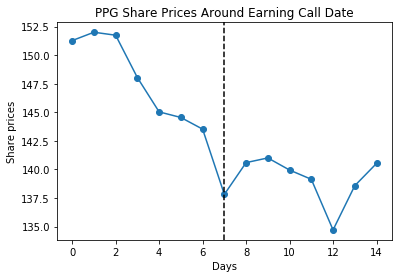

net price change = -0.7678571428571429
net price change BEFORE call = -1.3459991455078124
net price change AFTER call= -0.375
net price change BEFORE call = -1.3459991455078124
net price change AFTER call= -0.375

Sentiment: Neutral


In [ ]:
share_price_analyzer.showNetSharePriceChanges( 2)

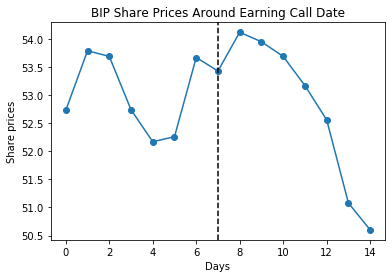

net price change = -0.15214293343680246
net price change BEFORE call = -0.094000244140625
net price change AFTER call= -0.38374996185302734
net price change BEFORE call = -0.094000244140625
net price change AFTER call= -0.38374996185302734

Sentiment: Neutral


In [ ]:
share_price_analyzer.showNetSharePriceChanges(90)

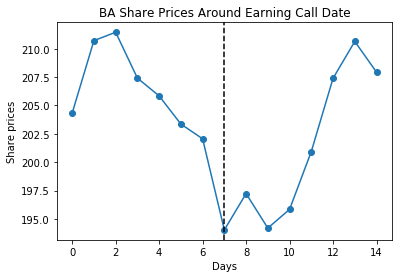

net price change = 0.25785609654017855
net price change BEFORE call = -0.1920013427734318
net price change AFTER call= 0.7337493896484482
net price change BEFORE call = -0.1920013427734318
net price change AFTER call= 0.7337493896484482

Sentiment: Negative


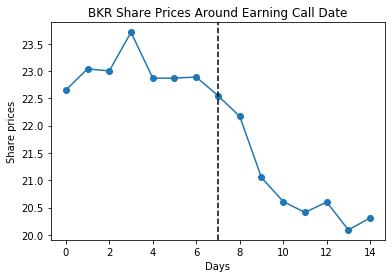

net price change = -0.16714286804199194
net price change BEFORE call = 0.044000244140625
net price change AFTER call= -0.32249999046325684
net price change BEFORE call = 0.044000244140625
net price change AFTER call= -0.32249999046325684

Sentiment: Positive


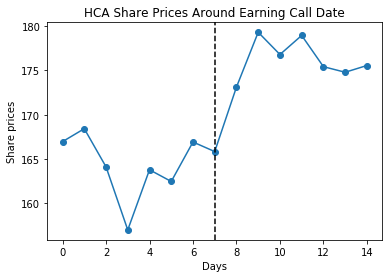

net price change = 0.6128572736467633
net price change BEFORE call = -0.8980010986328125
net price change AFTER call= 1.0775012969970703
net price change BEFORE call = -0.8980010986328125
net price change AFTER call= 1.0775012969970703

Sentiment: Negative


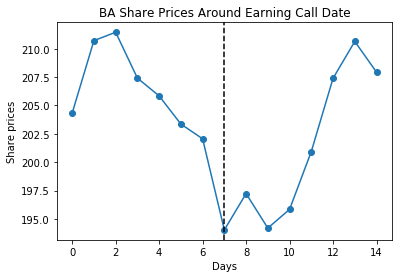

net price change = 0.25785609654017855
net price change BEFORE call = -0.1920013427734318
net price change AFTER call= 0.7337493896484482
net price change BEFORE call = -0.1920013427734318
net price change AFTER call= 0.7337493896484482

Sentiment: Negative


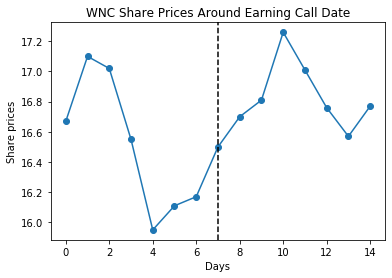

net price change = 0.007142884390694755
net price change BEFORE call = -0.11199989318847656
net price change AFTER call= 0.07500004768371582
net price change BEFORE call = -0.11199989318847656
net price change AFTER call= 0.07500004768371582

Sentiment: Negative


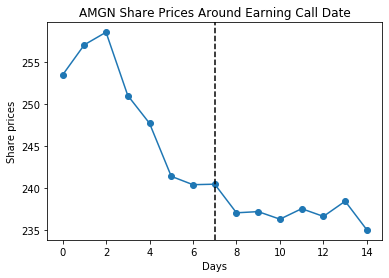

net price change = -1.3185719081333704
net price change BEFORE call = -2.41400146484375
net price change AFTER call= -0.6737499237060547
net price change BEFORE call = -2.41400146484375
net price change AFTER call= -0.6737499237060547

Sentiment: Neutral


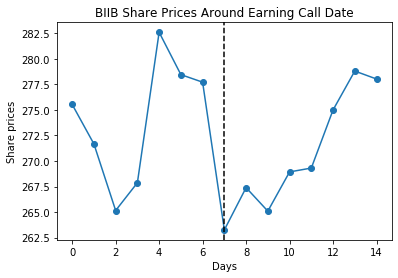

net price change = 0.1778564453125
net price change BEFORE call = 0.5839965820312273
net price change AFTER call= 0.03874969482423296
net price change BEFORE call = 0.5839965820312273
net price change AFTER call= 0.03874969482423296

Sentiment: Neutral


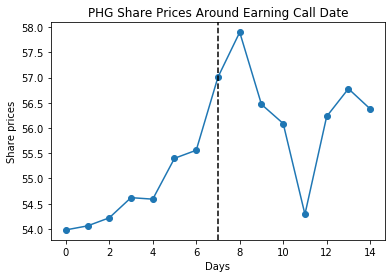

net price change = 0.17142868041992138
net price change BEFORE call = 0.2840003967285142
net price change AFTER call= 0.10249996185302557
net price change BEFORE call = 0.2840003967285142
net price change AFTER call= 0.10249996185302557

Sentiment: Neutral


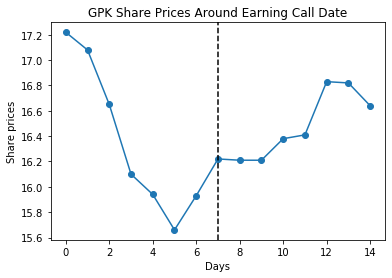

net price change = -0.041428565979003906
net price change BEFORE call = -0.31199989318847654
net price change AFTER call= 0.08874988555908225
net price change BEFORE call = -0.31199989318847654
net price change AFTER call= 0.08874988555908225

Sentiment: Negative


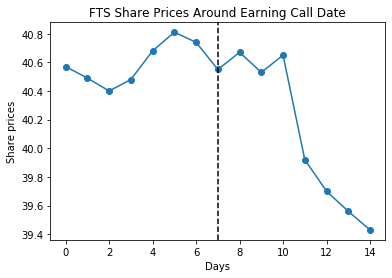

net price change = -0.08142852783203125
net price change BEFORE call = 0.048000335693359375
net price change AFTER call= -0.16375017166137695
net price change BEFORE call = 0.048000335693359375
net price change AFTER call= -0.16375017166137695

Sentiment: Positive


In [ ]:
for _ in range(0,10):
    share_price_analyzer.showNetSharePriceChanges(randrange(100))

# FinancialPhraseBank class

In [ ]:
class FinancialPhraseBank():
    
    def __init__(self):
        self.__data_csv_path = ''
        self.__df = ''
    
    def load(self, data_csv_path):
        self.__data_csv_path = data_csv_path
        self.__df = pd.read_csv(data_csv_path, encoding='ISO-8859-1',header=None)
        self.__df.columns = ['Polarity', 'Data']
        self.__df['PolarityAsInt'] = self.__df.apply (lambda row: self.__translatePolarityToInt(row), axis=1)
        
        #print(self.__df.head())
        
    
    def plotPolarityHist(self):
        #plt.xlabel('Polarity')
        #plt.hist(self.__df['Polarity'])
        #self.__df.hist(column='PolarityAsInt')
        self.__df.plot(x='Polarity', kind = 'hist')
        
        
    def trainValidationTestSplitAsDataset(self, useNeutralPolarity=True, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10):
        train, val, test = self.trainValidationTestSplit(useNeutralPolarity, train_ratio, validation_ratio, test_ratio)
        
        train_ds = self.__convertDataFrameToDataset(train)
        val_ds = self.__convertDataFrameToDataset(val)
        test_ds = self.__convertDataFrameToDataset(test)
        
        return train_ds, val_ds, test_ds
     
    
    def trainValidationTestSplit(self, useNeutralPolarity = True, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10):
        
        # Separate data by polarity
        df_pos, df_neg, df_ntrl = self.__separateDataByPolarity()
        
        # Create a train validation and test split per polarity 
        train_pos , val_pos, test_pos = self.__trainValidationTestSplit(df_pos, train_ratio, validation_ratio, test_ratio)

        train_neg , val_neg, test_neg = self.__trainValidationTestSplit(df_neg, train_ratio, validation_ratio, test_ratio)

        train_ntrl , val_ntrl, test_ntrl = self.__trainValidationTestSplit(df_ntrl, train_ratio, validation_ratio, test_ratio)
        
        if useNeutralPolarity == True:
            test = pd.concat([test_pos, test_neg, test_ntrl], axis=0).sample(frac = 1) 
            val = pd.concat([val_pos, val_neg, val_ntrl], axis=0).sample(frac = 1) 
            train = pd.concat([train_pos, train_neg, train_ntrl], axis=0).sample(frac = 1) 
        else:
            test = pd.concat([test_pos, test_neg], axis=0).sample(frac = 1) 
            val = pd.concat([val_pos, val_neg], axis=0).sample(frac = 1) 
            train = pd.concat([train_pos, train_neg], axis=0).sample(frac = 1) 

        return train, val, test
    
    def __trainValidationTestSplit(self, data, train_ratio, validation_ratio, test_ratio):
        
        if(len(data) == 0):
            df = pd.DataFrame() 
            return df, df ,df
        # train is now train_ratio pervent of the entire data set
        # the _junk suffix means that we drop that variable completely
        train, test = train_test_split(data, test_size=1 - train_ratio, random_state=1)

        # test is now test_ration% of the initial data set
        # validation is now 15% of the initial data set
        val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=1) 

        return train, val, test


    def __separateDataByPolarity(self):
        df_pos = self.__df[self.__df['PolarityAsInt'] == 1]
        #df_pos = df_pos.drop('Polarity', 1)

        df_neg = self.__df[self.__df['PolarityAsInt'] == 0]
        #df_neg = df_neg.drop('Polarity', 1)

        df_ntrl = self.__df[self.__df['PolarityAsInt'] == 2]
        #df_ntrl = df_ntrl.drop('Polarity', 1)

        return df_pos, df_neg, df_ntrl
        
    
    def __translatePolarityToInt (self, row):
        if row['Polarity'] == 'negative':
            return 0
        if row['Polarity'] == 'positive':
            return 1
        if row['Polarity'] == 'neutral':
            return 2
        return 3

    
    def __convertDataFrameToDataset(self, df):
        ds = (
          tf.data.Dataset.from_tensors(
          #tf.data.Dataset.from_tensor_slices(
              (
                  tf.cast(df['Data'].values, tf.string),
                  tf.cast(df['PolarityAsInt'].values, tf.int32)
              )
          )
        )
        return ds

        

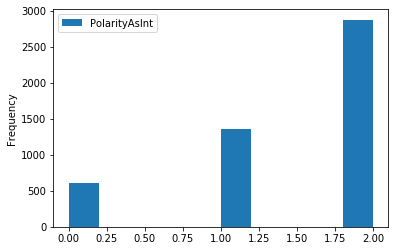

In [ ]:
fin_phrase_bank = FinancialPhraseBank()


fin_phrase_bank.load(ROOT_DIR + '/FinancialPhraseBank.csv')

fin_phrase_bank.plotPolarityHist()


#phrase_bank_train, phrase_bank_val, phrase_bank_test = fin_phrase_bank.trainValidationTestSplit(useNeutralPolarity=False)

#print(f'train shape: {phrase_bank_train.shape}')
#print(f'validaion shape: {phrase_bank_val.shape}')
#print(f'test shape: {phrase_bank_test.shape}')


#phrase_bank_train_ds, phrase_bank_val_ds, phrase_bank_test_ds = fin_phrase_bank.trainValidationTestSplitAsDataset(useNeutralPolarity=True)

In [ ]:
class FinBert():
    
    def __init__(self):
        self.__init_lr = 3e-5
        self.__epochs = 5
        
     
    @property
    def epochs(self):
        return self.__epochs
    
    @property
    def model(self):
        return self.__model
    
    def loadModel(self, preprocess_handle, encoder_handle, classification_num):
        self.__model = self.__build_classifier_model(preprocess_handle, encoder_handle, classification_num)
        
    def compile(self, epochs, train_ds):
        self.__epochs = epochs
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metrics = tf.metrics.SparseCategoricalAccuracy()
        steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
        num_train_steps = steps_per_epoch * self.__epochs
        num_warmup_steps = int(0.1*num_train_steps)

        self.__init_lr = 3e-5
        optimizer = optimization.create_optimizer(init_lr=self.__init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
        self.__model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
        
        
    def fit(self, x, validation_data):
        self.__history = self.__model.fit(x=x,validation_data=validation_data,epochs=self.__epochs)
        return self.__history
    
    
    def predict(self, test):
        self.__y_predict = self.__model.predict(test)
        y_predict_class = []
        for arr in self.__y_predict:
            y_predict_class.append(np.argmax(arr))
        return (self.__y_predict, y_predict_class)
        
        
    def saveModel(self, file_path):
        print(f'Saving model to {file_path}')
        self.__model.save(file_path)
        
    def summary(self):
        self.__model.summary()
        
    def __build_classifier_model(self, preprocess_handle, encoder_handle, classification_num):
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(preprocess_handle, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(encoder_handle, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(classification_num, activation='softmax', name='classifier')(net)
    
        return tf.keras.Model(text_input, net)
    
    
    # summarize history for accuracy
    def plotAccuracy(self):
        plt.plot(self.__history.history['sparse_categorical_accuracy'])
        plt.plot(self.__history.history['val_sparse_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
    # summarize history for loss
    def plotLoss(self):    
        plt.plot(self.__history.history['loss'])
        plt.plot(self.__history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
    

In [ ]:
class EarningCallsBert():
    def __init__(self):
        self.__init_lr = 3e-5
        self.__epochs = 5
        
     
    @property
    def epochs(self):
        return self.__epochs
    
    def loadModel(self, model_path, classification_num):
        model = keras.models.load_model(model_path,custom_objects={'KerasLayer':hub.KerasLayer}, compile=False)
        model._layers.pop()
        net = tf.keras.layers.Dense(128, activation='relu', name='dense')(model.layers[-1].output)
        net = tf.keras.layers.Dense(classification_num, activation='softmax', name='classifier')(net)
        #net = tf.keras.layers.Dense(classification_num, activation='softmax', name='classifier')(model.layers[-1].output)
        self.__model = tf.keras.Model(model.layers[0].input, net)
        
   
        
    def compile(self, epochs, train_ds):
        self.__epochs = epochs
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metrics = tf.metrics.SparseCategoricalAccuracy()
        steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
        num_train_steps = steps_per_epoch * self.__epochs
        num_warmup_steps = int(0.1*num_train_steps)

        self.__init_lr = 3e-5
        optimizer = optimization.create_optimizer(init_lr=self.__init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
        self.__model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
        
        
    def fit(self, x, validation_data):
        self.__history = self.__model.fit(x=x,validation_data=validation_data,epochs=self.__epochs)
        return self.__history
        
    
    def predict(self, test):
        self.__y_predict = self.__model.predict(test)
        y_predict_class = []
        for arr in self.__y_predict:
            y_predict_class.append(np.argmax(arr))
        return (self.__y_predict, y_predict_class)
        
    def saveModel(self, file_path):
        print(f'Saving model to {file_path}')
        self.__model.save(file_path)
        
        
             
    def summary(self):
        self.__model.summary()
        
    # summarize history for accuracy
    def plotAccuracy(self):
        plt.plot(self.__history.history['sparse_categorical_accuracy'])
        plt.plot(self.__history.history['val_sparse_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
    # summarize history for loss
    def plotLoss(self):    
        plt.plot(self.__history.history['loss'])
        plt.plot(self.__history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
    

In [ ]:
def plotConfusionMatrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, lables = ['Negative', 'Positive']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, lables, rotation=45)
    plt.yticks(tick_marks, lables)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def calculateAccuracy(y_actual, y_predict):
    correct_num = 0
    print(y_actual)
    print(y_predict)
    for i in range(0, len(y_actual)):
        if y_actual[i] == y_predict[i]:
            correct_num = correct_num + 1
    return correct_num / len(y_actual)


def classificationReport(y_actual, y_predict, labels=['Negative', 'Positive']):
    print(metrics.classification_report(y_actual, y_predict))#, target_names=labels))
    
    cm = metrics.confusion_matrix(y_actual, y_predict)
    plt.figure()
    plotConfusionMatrix(cm)
    print(metrics.confusion_matrix(y_actual, y_predict))
    print(f'Predict Accuracy: {calculateAccuracy(y_actual, y_predict)}')


In [ ]:
# Possible sentimet_type values:
#    AvgNetPriceChange - Average net price change difference before and after the call
#    FirstDayChange - Price change between the day of the earning call and the following day.
#    PostCallNetChange - Average net price change in the week after the earning call
#    PostCallPctChange - The percent change in prices between the day of the call and the week after the call
sentiment_type='PostCallPctChange'

# FinancialPhraseBank training set using Positive, Negative and Neutral for classification 
phrase_bank_train_ds_3, phrase_bank_val_ds_3, phrase_bank_test_ds_3 = fin_phrase_bank.trainValidationTestSplitAsDataset(useNeutralPolarity=True)

# FinancialPhraseBank training set using Positive and Negative only for classification
phrase_bank_train_ds_2, phrase_bank_val_ds_2, phrase_bank_test_ds_2 = fin_phrase_bank.trainValidationTestSplitAsDataset(useNeutralPolarity=False)


# Earning calls training set using Positive, Negative and Neutral for classification 
earning_calls_train_ds_3, earning_calls_val_ds_3, earning_calls_test_ds_3 = corpus.trainValidationTestSplitAsDataset(useNeutralPolarity=True, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10, sentiment_type=sentiment_type)

# Earning calls training set using Positive and Negative only for classification
earning_calls_train_ds_2, earning_calls_val_ds_2, earning_calls_test_ds_2 = corpus.trainValidationTestSplitAsDataset(useNeutralPolarity=False, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10, sentiment_type=sentiment_type)


# Number of classifications to use in the model
classification_num_2 = 2
classification_num_3 = 3

In [ ]:
# BERT encoder and preprocess to use
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
epochs_num = 5

In [ ]:
# Setting file paths for saved models
dataset_name = 'FinancialPhraseBank_epochs_' + str(epochs_num) + '_3_classifications'
fin_bert_saved_model_path_3_classifications = ROOT_DIR + '/{}_bert'.format(dataset_name.replace('/', '_'))


dataset_name = 'FinancialPhraseBank_epochs_' + str(epochs_num) + '_2_classifications'
fin_bert_saved_model_path_2_classifications = ROOT_DIR + '/{}_bert'.format(dataset_name.replace('/', '_'))

# Test 1 - Fin-BERT using 3 classifications

Using Fin-BERT model with 3 classifications (Positive, Negative, Neutral).

The model uses BERT to train on the FinancialPhraseBank dataset

In [ ]:
fin_bert_model_3_classes = FinBert();

fin_bert_model_3_classes.loadModel(preprocess_handle = tfhub_handle_preprocess, encoder_handle = tfhub_handle_encoder, classification_num = classification_num_3)

fin_bert_model_3_classes.compile(epochs=epochs_num, train_ds = phrase_bank_train_ds_3)

fin_bert_model_3_classes.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [ ]:
fin_bert_model_3_classes_history = fin_bert_model_3_classes.fit(x=phrase_bank_train_ds_3,validation_data=phrase_bank_val_ds_3)

Epoch 1/5
1/1 [==============================] - 55s 55s/step - loss: 1.3982 - sparse_categorical_accuracy: 0.2124 - val_loss: 1.3582 - val_sparse_categorical_accuracy: 0.1694
Epoch 2/5
1/1 [==============================] - 41s 41s/step - loss: 1.3521 - sparse_categorical_accuracy: 0.2367 - val_loss: 1.3069 - val_sparse_categorical_accuracy: 0.1928
Epoch 3/5
1/1 [==============================] - 45s 45s/step - loss: 1.3091 - sparse_categorical_accuracy: 0.2653 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.2094
Epoch 4/5
1/1 [==============================] - 49s 49s/step - loss: 1.2756 - sparse_categorical_accuracy: 0.2771 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.2163
Epoch 5/5
1/1 [==============================] - 41s 41s/step - loss: 1.2595 - sparse_categorical_accuracy: 0.2969 - val_loss: 1.2359 - val_sparse_categorical_accuracy: 0.2259


In [ ]:
# Save model
fin_bert_model_3_classes.saveModel(fin_bert_saved_model_path_3_classifications)

Saving model to /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_3_classifications_bert


INFO:tensorflow:Assets written to: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_3_classifications_bert/assets


INFO:tensorflow:Assets written to: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_3_classifications_bert/assets


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       5.0
           1       0.00      0.00      0.00       6.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00      11.0
   macro avg       0.00      0.00      0.00      11.0
weighted avg       0.00      0.00      0.00      11.0

[[0 0 5]
 [0 0 6]
 [0 0 0]]
[0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predict Accuracy: 0.0


/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sh

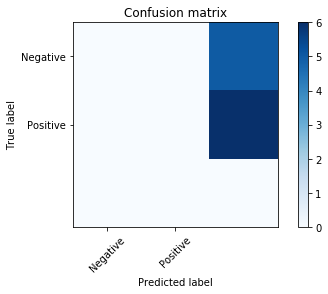

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_3], axis=0).tolist()
_ , y_predict= fin_bert_model_3_classes.predict(earning_calls_test_ds_3)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive', 'Neutral'])

# Test 2 - Fin-BERT using 2 classifications

Using Fin-BERT model with 2 classifications (Positive, Negative).

The model uses BERT to train on the FinancialPhraseBank dataset


In [ ]:
fin_bert_model_2_classes = FinBert();

fin_bert_model_2_classes.loadModel(preprocess_handle = tfhub_handle_preprocess, encoder_handle = tfhub_handle_encoder, classification_num = classification_num_2)

fin_bert_model_2_classes.compile(epochs=epochs_num, train_ds = phrase_bank_train_ds_2)

fin_bert_model_2_classes.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
fin_bert_model_2_classes_history = fin_bert_model_2_classes.fit(x=phrase_bank_train_ds_2,validation_data=phrase_bank_val_ds_2)

Epoch 1/5
1/1 [==============================] - 17s 17s/step - loss: 0.8675 - sparse_categorical_accuracy: 0.4414 - val_loss: 0.8327 - val_sparse_categorical_accuracy: 0.4048
Epoch 2/5
1/1 [==============================] - 12s 12s/step - loss: 0.8233 - sparse_categorical_accuracy: 0.4563 - val_loss: 0.7861 - val_sparse_categorical_accuracy: 0.4150
Epoch 3/5
1/1 [==============================] - 12s 12s/step - loss: 0.7824 - sparse_categorical_accuracy: 0.4881 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.4626
Epoch 4/5
1/1 [==============================] - 12s 12s/step - loss: 0.7605 - sparse_categorical_accuracy: 0.5003 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.4728
Epoch 5/5
1/1 [==============================] - 12s 12s/step - loss: 0.7440 - sparse_categorical_accuracy: 0.5397 - val_loss: 0.7268 - val_sparse_categorical_accuracy: 0.4796


In [ ]:
# Save model
fin_bert_model_2_classes.saveModel(fin_bert_saved_model_path_2_classifications)

Saving model to /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_2_classifications_bert


INFO:tensorflow:Assets written to: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_2_classifications_bert/assets


INFO:tensorflow:Assets written to: /Users/shacharerez/Documents/Northwestern/498 - AI Capstone/FinancialPhraseBank_epochs_5_2_classifications_bert/assets


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.55      1.00      0.71         6

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11

[[0 5]
 [0 6]]
[1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predict Accuracy: 0.5454545454545454


/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


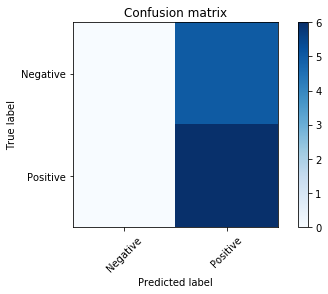

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_2], axis=0).tolist()
_ , y_predict= fin_bert_model_2_classes.predict(earning_calls_test_ds_2)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive'])

# Test 3 - Training EarningCalls-BERT using Fin-BERT as base and
# 3 classifications

Using EarningsCall-BERT model with 3 classifications (Positive, Negative, Neutral), using Fin_BERT 3 classifications as the base of the model

The model uses the earning calls corpus as dataset


In [ ]:
earning_calls_model_3_classes_with_Fin_Bert = EarningCallsBert()

earning_calls_model_3_classes_with_Fin_Bert.loadModel(model_path = fin_bert_saved_model_path_3_classifications, classification_num=classification_num_3)

earning_calls_model_3_classes_with_Fin_Bert.compile(epochs=epochs_num, train_ds = earning_calls_train_ds_3)

earning_calls_model_3_classes_with_Fin_Bert.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 1 4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
earning_calls_3_with_Fin_Bert_history = earning_calls_model_3_classes_with_Fin_Bert.fit(x=earning_calls_train_ds_3,validation_data=earning_calls_val_ds_3)


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 9s 9s/step - loss: 1.2208 - sparse_categorical_accuracy: 0.2162 - val_loss: 1.2114 - val_sparse_categorical_accuracy: 0.1333
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 1.1618 - sparse_categorical_accuracy: 0.2568 - val_loss: 1.1301 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 1.0991 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 1.0803 - sparse_categorical_accuracy: 0.3784 - va

              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         0

    accuracy                           0.27        11
   macro avg       0.14      0.20      0.17        11
weighted avg       0.19      0.27      0.23        11

[[3 1 1]
 [4 0 2]
 [0 0 0]]
[0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
[2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0]
Predict Accuracy: 0.2727272727272727


/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


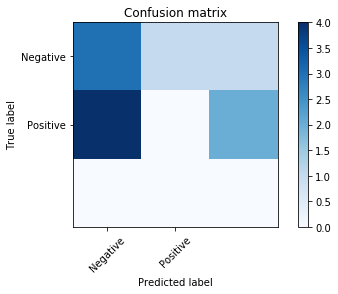

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_3], axis=0).tolist()
_ , y_predict= earning_calls_model_3_classes_with_Fin_Bert.predict(earning_calls_test_ds_3)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive', 'Neutral'])

# Test 4 - Training EarningCalls-BERT using Fin-BERT as base and
# 2 classifications

Using EarningsCall-BERT model with 2 classifications (Positive, Negative), using Fin_BERT 2 classifications as the base of the model

The model uses the earning calls corpus as dataset


In [ ]:
earning_calls_model_2_classes_with_Fin_Bert = EarningCallsBert()

earning_calls_model_2_classes_with_Fin_Bert.loadModel(model_path = fin_bert_saved_model_path_2_classifications, classification_num=classification_num_2)

earning_calls_model_2_classes_with_Fin_Bert.compile(epochs=epochs_num, train_ds = earning_calls_train_ds_2)

earning_calls_model_2_classes_with_Fin_Bert.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
earning_calls_2_with_Fin_Bert_history = earning_calls_model_2_classes_with_Fin_Bert.fit(x=earning_calls_train_ds_2,validation_data=earning_calls_val_ds_2)


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: 0.8302 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.7525 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.8094 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.7187 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.7677 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.8095 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.7390 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.6000


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.55      1.00      0.71         6

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11

[[0 5]
 [0 6]]
[1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predict Accuracy: 0.5454545454545454


/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shacharerez/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


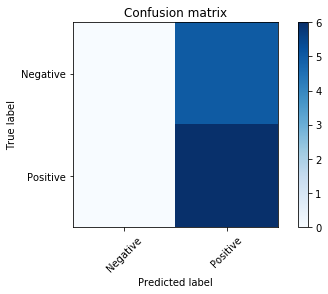

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_2], axis=0).tolist()
_ , y_predict= earning_calls_model_2_classes_with_Fin_Bert.predict(earning_calls_test_ds_2)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive'])

# Test 5 - Fin-BERT using 3 classifications and Corpus

Using Fin-BERT model with 3 classifications (Positive, Negative, Neutral).

The model uses BERT to train on the earning calls corpus dataset


In [ ]:
fin_bert_model_3_classes_corpus = FinBert();

fin_bert_model_3_classes_corpus.loadModel(preprocess_handle = tfhub_handle_preprocess, encoder_handle = tfhub_handle_encoder, classification_num = classification_num_3)

fin_bert_model_3_classes_corpus.compile(epochs=epochs_num, train_ds = earning_calls_train_ds_3)

fin_bert_model_3_classes_corpus.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 1 4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
fin_bert_model_3_classes_corpus_history = fin_bert_model_3_classes_corpus.fit(x=earning_calls_train_ds_3,validation_data=earning_calls_train_ds_3)


Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 1.5193 - sparse_categorical_accuracy: 0.1757 - val_loss: 1.2874 - val_sparse_categorical_accuracy: 0.2703
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 1.3298 - sparse_categorical_accuracy: 0.3108 - val_loss: 1.2302 - val_sparse_categorical_accuracy: 0.3108
Epoch 3/5
1/1 [==============================] - 4s 4s/step - loss: 1.2059 - sparse_categorical_accuracy: 0.3919 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.3514
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 1.2156 - sparse_categorical_accuracy: 0.3649 - val_loss: 1.1677 - val_sparse_categorical_accuracy: 0.3784
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 1.2560 - sparse_categorical_accuracy: 0.3649 - val_loss: 1.1563 - val_sparse_categorical_accuracy: 0.3784


              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.56      0.83      0.67         6

    accuracy                           0.55        11
   macro avg       0.53      0.52      0.48        11
weighted avg       0.53      0.55      0.49        11

[[1 4]
 [1 5]]
[0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Predict Accuracy: 0.5454545454545454


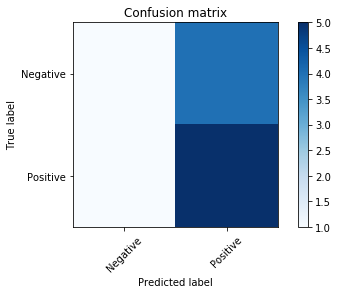

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_3], axis=0).tolist()
_ , y_predict= fin_bert_model_3_classes_corpus.predict(earning_calls_test_ds_3)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive', 'Neutral'])

# Test 6 - Fin-BERT using 2 classifications and Corpus

Using Fin-BERT model with 2 classifications (Positive, Negative).

The model uses BERT to train on the earning calls corpus dataset


In [ ]:
fin_bert_model_2_classes_corpus = FinBert();

fin_bert_model_2_classes_corpus.loadModel(preprocess_handle = tfhub_handle_preprocess, encoder_handle = tfhub_handle_encoder, classification_num = classification_num_2)

fin_bert_model_2_classes_corpus.compile(epochs=epochs_num, train_ds = earning_calls_train_ds_2)

fin_bert_model_2_classes_corpus.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
fin_bert_model_2_classes_corpus_history = fin_bert_model_2_classes_corpus.fit(x=earning_calls_train_ds_2,validation_data=earning_calls_train_ds_2)


Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.9218 - sparse_categorical_accuracy: 0.4189 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.3919
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.8836 - sparse_categorical_accuracy: 0.4324 - val_loss: 0.8042 - val_sparse_categorical_accuracy: 0.3919
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 0.9062 - sparse_categorical_accuracy: 0.3514 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.3919
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 0.8931 - sparse_categorical_accuracy: 0.4054 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.4324
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 0.7590 - sparse_categorical_accuracy: 0.4595 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.4189


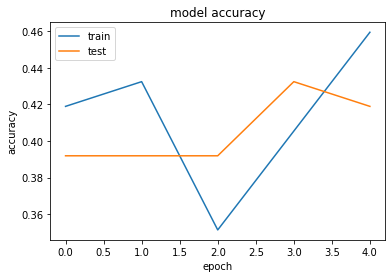

In [ ]:
fin_bert_model_2_classes_corpus.plotAccuracy()

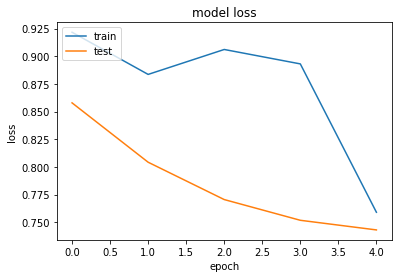

In [ ]:
fin_bert_model_2_classes_corpus.plotLoss()

              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.50      0.33      0.40         6

    accuracy                           0.45        11
   macro avg       0.46      0.47      0.45        11
weighted avg       0.47      0.45      0.45        11

[[3 2]
 [4 2]]
[1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Predict Accuracy: 0.45454545454545453


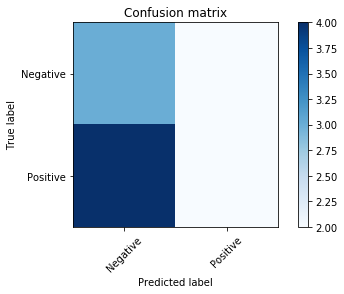

In [ ]:
y_actual = np.concatenate([y for x, y in earning_calls_test_ds_2], axis=0).tolist()
_ , y_predict= fin_bert_model_2_classes_corpus.predict(earning_calls_test_ds_2)
classificationReport(y_actual, y_predict, labels=['Negative', 'Positive'])
